In [1]:
import shutil
import os

import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
    
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [2]:
#dataset = pd.read_csv('data20201014/KL234_balanced_5_12_20.dta_forJH_impmedian.csv')

#dataset = pd.read_csv('data20201025/KL234_balanced_10_23_20.csv')
#dataset = pd.read_csv('data20201025/KL234_doublecontrol_10_23_20.csv')
#dataset = pd.read_csv('data20201025/KL234_unbalanced_10_23_20.csv') #does not appear to work for some reason
#dataset = pd.read_csv('data20201025/KL234_balanced_10_23_20_only10.csv')
#dataset = pd.read_csv('data20201025/KL234_unbalanced_10_23_20_only10.csv') #hyperparameters were optimized for this dataset
dataset = pd.read_csv('data20201025/KL234_unbalanced_10_23_20_new.csv')
os.getcwd()

'C:\\Users\\sohn\\Google Drive\\Research\\2020 Gabby MSK knee OA prediction'

In [3]:
dataset.shape

(1044, 114)

In [4]:
#Organize Dataset & Generate Train/Test/Val split.
trainval_test_rand_seed=45
train_val_rand_seed=23

X = dataset.iloc[:, 2:113].values
#X = dataset
y = dataset.iloc[:, 1].values

feature_names = dataset.head()
featurenames3 = list(feature_names)
featurenames4 = featurenames3[2:113]
#featurenames4

from sklearn.model_selection import train_test_split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, y, test_size=0.2, random_state=trainval_test_rand_seed)
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, random_state=train_val_rand_seed)

D_train = xgb.DMatrix(X_train, label=Y_train, feature_names=featurenames4)
D_train.feature_names
D_val = xgb.DMatrix(X_val, label=Y_val, feature_names=featurenames4)
#D_val.feature_names

In [140]:
featurenames4

['p01bmi',
 'v00age',
 'p02sex_01',
 'v00womkpr',
 'v00remaxf',
 'v00rfmaxf',
 'ave_t2_v00',
 'v00_r_lf_mean_t2',
 'v00_r_lt_mean_t2',
 'v00_r_mf_mean_t2',
 'v00_r_mt_mean_t2',
 'v00_r_pat_mean_t2',
 'v00_r_cartlesp',
 'v00_r_cartlest',
 'v00_r_cartlesmfc',
 'v00_r_cartleslfc',
 'v00_r_cartlesmt',
 'v00_r_cartleslt',
 'v00_r_menmedanttype',
 'v00_r_menmedbodytype',
 'v00_r_menmedposttype',
 'v00_r_menlatanttype',
 'v00_r_menlatbodytype',
 'v00_r_menlatposttype',
 'v00_r_bmep',
 'v00_r_bmet',
 'v00_r_bmemfc',
 'v00_r_bmelfc',
 'v00_r_bmemt',
 'v00_r_bmelt',
 'menmax_v00',
 'cartmax_v00',
 'bmemax_v00',
 'p02race',
 'p02hisp',
 'p02kinj',
 'v00_r_effusion',
 'v00bpsys',
 'v00bpdias',
 'v00rpavg',
 'v00cstime1',
 'v00cstime2',
 'v00timet1',
 'v00rkpatpn',
 'v00rkeffb',
 'v00rkeffpt',
 'v00rkrfxpn',
 'v00rklttpn',
 'v00rkmttpn',
 'v00rkabpn',
 'v00rkpfcre',
 'v00rkpgdpn',
 'v00rlwgt',
 'v00abcirc',
 'v00rkalnmt',
 'v00rftlpl',
 'v00rfthpl',
 'v00rftlrl',
 'v00rfthrl',
 'v00retlpl',
 'v00re

In [5]:
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)

# grid search
model = XGBClassifier()
#n_estimators = [25,50,75,250]
#learning_rate=[0.2, 0.1, 0.05, 0.005]
#gamma=[0, 0.1,0.2,0.5]
#max_depth = [2,4,5,10,30,100]
#min_child_weight=[1,2,3,5,10,30]
n_estimators = [25,50]
learning_rate=[0.2, 0.1, 0.05]
gamma=[0.2, 0.1, 0]
max_depth = [30, 10, 5]
min_child_weight=[3, 2]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, gamma=gamma, 
                  learning_rate=learning_rate,min_child_weight=min_child_weight)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#	print("%f (%f) with: %r" % (mean, stdev, param))

param=grid_result.best_params_
param.update([('objective', 'binary:logistic'), ('eval_metric', 'auc')])
param

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.1s


Best: 0.718166 using {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 25}


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   45.1s finished


{'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 25,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [7]:
#define parameters from the gridsearch
param = {'n_estimators': 50,
    'learning_rate':0.1,
    'lambda': 20,
    'eta': 0.1,
    'gamma': 0,
    'max_depth': 10,  
    'objective': 'binary:logistic', 
    'min_child_weight': 3,
    'reg_lambda': 0,
    'reg_alpha': 1,
    'max_delta_step': 100,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'eval_metric': 'auc'}

In [8]:
#param=grid_result.best_params_
num_round = 20
watchlist = [(D_val,'val'), (D_train,'train')]
steps = 30 # The number of training iterations

# train our model 
evals_result = {}
model = xgb.train(param, D_train, num_round, watchlist, evals_result=evals_result)
#model.save_model('/Users/gabby/Google Drive/Jae_ho_project/OA project/model_output/1_30_opt1.model') # save model
    
#Model Evaluation
D_test = xgb.DMatrix(X_test, label=Y_test, feature_names=featurenames4)
model.predict(D_test) #tell u the prediction values
prediction =  model.predict(D_test)
#np.savetxt('/Users/gabby/Google Drive/Jae_ho_project/OA project/model_output/pred_1_30.csv', prediction, delimiter=",")

fpr1, tpr1, threshold4 = roc_curve(Y_test, prediction)
roc_auc1 = auc(fpr1, tpr1)
print(roc_auc1)

[13:17:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	val-auc:0.60974	train-auc:0.75443
[1]	val-auc:0.61266	train-auc:0.82531
[2]	val-auc:0.64838	train-auc:0.86560
[3]	val-auc:0.66061	train-auc:0.88852
[4]	val-auc:0.67089	train-auc:0.89536
[5]	val-auc:0.68041	train-auc:0.90440
[6]	val-auc:0.68647	train-auc:0.91043
[7]	val-auc:0.70022	train-auc:0.91561
[8]	val-auc:0.69329	train-auc:0.91912
[9]	val-auc:0.71710	train-auc:0.92349
[10]	val-auc:0.71385	train-auc:0.92949
[11]	val-auc:0.71082	train-auc:0.93249
[12]	val-auc:0.73030	train-auc:0.94172
[13]	val-auc:0.74221	train-auc:0.94320
[14]	val-auc:0.75238	train-auc:0.94467
[15]	val-auc:0.75433	train-auc:0.94

Text(0.5, 1.0, 'ROC Curve')

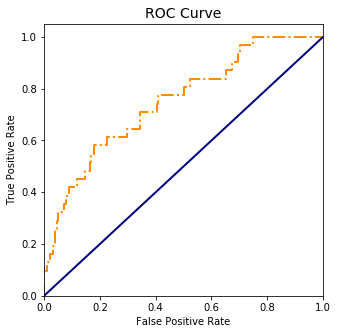

In [9]:
#ROC Curve Generation

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
lw = 2
ax.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label='ROC curve for F1 (area = %0.2f)' % roc_auc1, linestyle="-.")

ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.set_title('ROC Curve', fontsize=14)

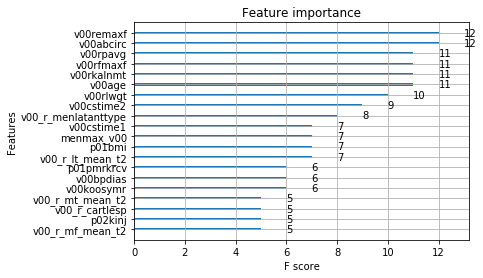

In [10]:
#Plot Important Features
from xgboost import plot_importance

plot_importance(model, max_num_features=20)
pyplot.show()

In [11]:
import sklearn.datasets
import sklearn.model_selection
import sklearn.linear_model    
import numpy
import compare_auc_delong_xu
import scipy.stats

x_distr = scipy.stats.norm(0.5, 1)
y_distr = scipy.stats.norm(-0.5, 1)
sample_size_x = 7
sample_size_y = 14
n_trials = 1000
aucs = numpy.empty(n_trials)
variances = numpy.empty(n_trials)
numpy.random.seed(1234235)
labels = numpy.concatenate([numpy.ones(sample_size_x), numpy.zeros(sample_size_y)])
for trial in range(n_trials):
    scores = numpy.concatenate([
        x_distr.rvs(sample_size_x),
        y_distr.rvs(sample_size_y)])
    aucs[trial] = sklearn.metrics.roc_auc_score(labels, scores)
    auc_delong, variances[trial] = compare_auc_delong_xu.delong_roc_variance(
        labels, scores)

print(f"Experimental variance {variances.mean():.4f}, "
      f"computed vairance {aucs.var():.4f}, {n_trials} trials")

Experimental variance 0.0135, computed vairance 0.0124, 1000 trials


In [24]:
import compare_auc_delong_xu
from compare_auc_delong_xu import compute_midrank
from compare_auc_delong_xu import calc_pvalue

In [28]:
prediction2 = prediction + 0.02

In [29]:
delong_roc_test(Y_test, prediction, prediction2)

array([[nan]])

In [27]:
prediction

array([0.11088975, 0.17758095, 0.11179048, 0.15486132, 0.1277028 ,
       0.13619405, 0.45305863, 0.16715795, 0.08979423, 0.23098822,
       0.30689624, 0.14779514, 0.18448015, 0.18880361, 0.28571615,
       0.09110492, 0.15550698, 0.23645177, 0.2599309 , 0.3648794 ,
       0.10884392, 0.13537925, 0.32794517, 0.35693923, 0.24987954,
       0.4551843 , 0.2403187 , 0.32154083, 0.10226031, 0.12747552,
       0.11139499, 0.32770193, 0.21139368, 0.1024398 , 0.259557  ,
       0.29287243, 0.19072074, 0.12663755, 0.5302344 , 0.2776843 ,
       0.29521707, 0.12014004, 0.24030145, 0.19929935, 0.252625  ,
       0.3027659 , 0.0976107 , 0.34502465, 0.1369279 , 0.1031486 ,
       0.19840209, 0.17838398, 0.4984482 , 0.11085301, 0.2250152 ,
       0.08748351, 0.10903669, 0.30814072, 0.21303925, 0.34567702,
       0.22321619, 0.30828077, 0.1090849 , 0.13626766, 0.45346493,
       0.12212184, 0.1743156 , 0.10735949, 0.09117358, 0.46402588,
       0.15329875, 0.40295687, 0.2422161 , 0.12169439, 0.13813

In [ ]:
median(prediction)